In [14]:
import time
import matplotlib.pyplot as plt
from flightgear_python.fg_if import TelnetConnection

import math
from IPython.display import display, clear_output
# Initialize vJoy device (assuming device ID 1)


def map_value(value, in_min, in_max, out_min, out_max):
    return int((value - in_min) * (out_max - out_min) / (in_max - in_min) + out_min)

# Connect to FlightGear
read_conn = TelnetConnection('localhost', 5500)  # For reading data
read_conn.connect()

hastakenoff = False



# Function to send elevator control input

def set_elevator(control_value):
    control_value = max(-1.0, min(1.0, control_value))
    read_conn.set_prop('/controls/flight/elevator', control_value)

# Function to send aileron control input
def set_aileron(control_value):
    control_value = max(-1.0, min(1.0, control_value))
    read_conn.set_prop('/controls/flight/aileron', control_value)

# Function to send rudder control input (for yaw)
def set_rudder(control_value):
    control_value = max(-1.0, min(1.0, control_value))
    read_conn.set_prop('/controls/flight/rudder', control_value)

# Function to get all orientation and position data
def get_orientation_and_position():
    orientation_data = read_conn.list_props('/orientation', recurse_limit=0)
    position_data = read_conn.list_props('/position', recurse_limit=0)
    
    pitch = float(orientation_data['properties']['/orientation/pitch-deg'])
    pitch_rate = float(orientation_data['properties']['/orientation/pitch-rate-degps'])
    roll = float(orientation_data['properties']['/orientation/roll-deg'])
    roll_rate = float(orientation_data['properties']['/orientation/roll-rate-degps'])
    yaw = float(orientation_data['properties']['/orientation/heading-deg'])
    yaw_rate = float(orientation_data['properties']['/orientation/yaw-rate-degps'])
    
    x = float(position_data['properties']['/position/longitude-deg'])
    y = float(position_data['properties']['/position/latitude-deg'])
    altitude = float(position_data['properties']['/position/altitude-ft'])
    
    return pitch, pitch_rate, roll, roll_rate, yaw, yaw_rate, x, y, altitude

# PID Controller
def pid_controller(target_value, current_value, current_rate, kp, ki, kd, integral_error, dt):
    error = target_value - current_value
    integral_error += error * dt
    integral_error = max(-10.0, min(10.0, integral_error))  # Prevent integral windup
    control_output = kp * error + ki * integral_error - kd * current_rate
    return control_output, integral_error

# Function to convert offsets (in meters) to latitude/longitude
def offset_to_latlon(lat, lon, east_offset, north_offset):
    # Earth's radius in meters
    R = 6378137.0
    # Convert offsets to radians
    dlat = north_offset / R
    dlon = east_offset / (R * math.cos(math.radians(lat)))
    # New position
    new_lat = lat + math.degrees(dlat)
    new_lon = lon + math.degrees(dlon)
    return new_lat, new_lon

# Initialize origin position
initial_pitch, _, initial_roll, _, initial_yaw, _, initial_x, initial_y, initial_altitude = get_orientation_and_position()
print(f"Origin set at: Lat={initial_y}, Lon={initial_x}, Yaw={initial_yaw}")

# Define waypoints as offsets (east, north) in meters from the origin
waypoints = [
    (3000,0),
    (3000,3000),
    (-1000,3000),
    (-1000,0),
    (0,0)
]

# Initialize current waypoint index
current_waypoint_index = 0

# PID parameters
target_pitch = 4
kp_pitch, ki_pitch, kd_pitch = -0.02, -0.006, -0.02

target_roll = 0
kp_roll, ki_roll, kd_roll = 0.01, 0.001, 0.006

target_yaw = initial_yaw  # Set initial yaw as target
kp_yaw, ki_yaw, kd_yaw = 0.09, 0.0, 0.02

# Altitude PID controller to adjust pitch target
target_altitude = 2000  # Example target altitude in feet
kp_altitude, ki_altitude, kd_altitude = 0.01, 0.0007, 0.01  # Altitude PID gains

# Initialize integral errors
integral_altitude_error = integral_pitch_error = integral_roll_error = integral_yaw_error = 0.0

# Initialize data arrays for plotting
time_data = []
pitch_data = []
roll_data = []
yaw_data = []
x_data = []
y_data = []
altitude_data = []

# Control loop
previous_time = time.time()
while True:
    current_time = time.time()
    dt = current_time - previous_time
    if dt <= 0.0:
        dt = 0.01

    # Get orientation and position data
    pitch, pitch_rate, roll, roll_rate, yaw, yaw_rate, x, y, altitude = get_orientation_and_position()


    # Convert current waypoint to lat/lon
    if current_waypoint_index < len(waypoints):
        east_offset, north_offset = waypoints[current_waypoint_index]
        target_lat, target_lon = offset_to_latlon(initial_y, initial_x, east_offset, north_offset)

        # Calculate desired yaw (heading) to the waypoint
        dx = target_lon - x
        dy = target_lat - y
        desired_yaw = math.degrees(math.atan2(dx, dy))  # atan2(dx, dy) gives heading in degrees
        desired_yaw = (desired_yaw + 360) % 360  # Normalize to 0-360


        # Set target yaw
        target_yaw = desired_yaw

        if target_yaw-yaw > 180:
            target_yaw=target_yaw-360
        if yaw-target_yaw >180:
            target_yaw=target_yaw+360


        # Check if close to waypoint
        distance = math.sqrt(dx**2 + dy**2)
        if distance < 0.0010:  # Threshold to switch to next waypoint (100 meters)
            current_waypoint_index += 1
            print(f"Reached waypoint {current_waypoint_index - 1}, moving to next waypoint.")



    #takeoff 
    if hastakenoff == False:
        target_yaw= initial_yaw
        print ("takeoff .......................................................................")
    if altitude > 500:
        hastakenoff = True
    
    # PID for target pitch
    target_pitch, integral_altitude_error = pid_controller(
        target_altitude, altitude, 0, kp_altitude, ki_altitude, kd_altitude, integral_altitude_error, dt
    )
    target_pitch = max(-15, min(15, target_pitch))

    # PID control for pitch
    elevator_input, integral_pitch_error = pid_controller(
        target_pitch, pitch, pitch_rate, kp_pitch, ki_pitch, kd_pitch, integral_pitch_error, dt
    )




    
    # PID control for yaw
    rudder_input, integral_yaw_error = pid_controller(
        target_yaw , yaw , yaw_rate, kp_yaw, ki_yaw, kd_yaw, integral_yaw_error, dt
    )

    target_roll=max(-45.0, min(45.0, 40*rudder_input))
    # PID control for roll
    aileron_input, integral_roll_error = pid_controller(
        target_roll, roll, roll_rate, kp_roll, ki_roll, kd_roll, integral_roll_error, dt
    )

    
    # Set control inputs
    set_elevator(elevator_input)
    set_aileron(aileron_input)
    set_rudder(rudder_input)
    #vjoy_device.update()

    # Store the data for plotting
    time_data.append(current_time)
    pitch_data.append(pitch)
    roll_data.append(roll)
    yaw_data.append(yaw)
    x_data.append(x)
    y_data.append(y)
    altitude_data.append(altitude)

    previous_time = current_time
    print(f"Current Yaw: {yaw}, Target Yaw: {target_yaw}, Distance to Waypoint: {distance}")
    display()

# Plotting the data after the loop ends
plt.figure(figsize=(10, 12))

# Plot orientation data
plt.subplot(4, 1, 1)
plt.plot(time_data, pitch_data, label='Pitch')
plt.ylabel('Pitch (degrees)')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(time_data, roll_data, label='Roll', color='orange')
plt.ylabel('Roll (degrees)')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(time_data, yaw_data, label='Yaw', color='green')
plt.ylabel('Yaw (degrees)')
plt.legend()

# Plot position data
plt.subplot(4, 1, 4)
plt.plot(time_data, altitude_data, label='Altitude', color='red')
plt.ylabel('Altitude (feet)')
plt.xlabel('Time (seconds)')
plt.legend()

plt.tight_layout()
plt.show()

# Plot x, y position data
plt.figure(figsize=(10, 6))
plt.plot(x_data, y_data, label='Flight Path', color='blue')
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.legend()
plt.show()

print("done")

Origin set at: Lat=25.26647036, Lon=55.34706448, Yaw=121.4936701
takeoff .......................................................................
Current Yaw: 121.4936564, Target Yaw: 121.4936701, Distance to Waypoint: 0.029800387520502625
takeoff .......................................................................
Current Yaw: 121.4936564, Target Yaw: 121.4936701, Distance to Waypoint: 0.029800387520502625
takeoff .......................................................................
Current Yaw: 121.4936701, Target Yaw: 121.4936701, Distance to Waypoint: 0.029800387520502625
takeoff .......................................................................
Current Yaw: 121.4936837, Target Yaw: 121.4936701, Distance to Waypoint: 0.029800387520502625
takeoff .......................................................................
Current Yaw: 121.4936837, Target Yaw: 121.4936701, Distance to Waypoint: 0.029800387520502625
takeoff .........................................................

KeyboardInterrupt: 

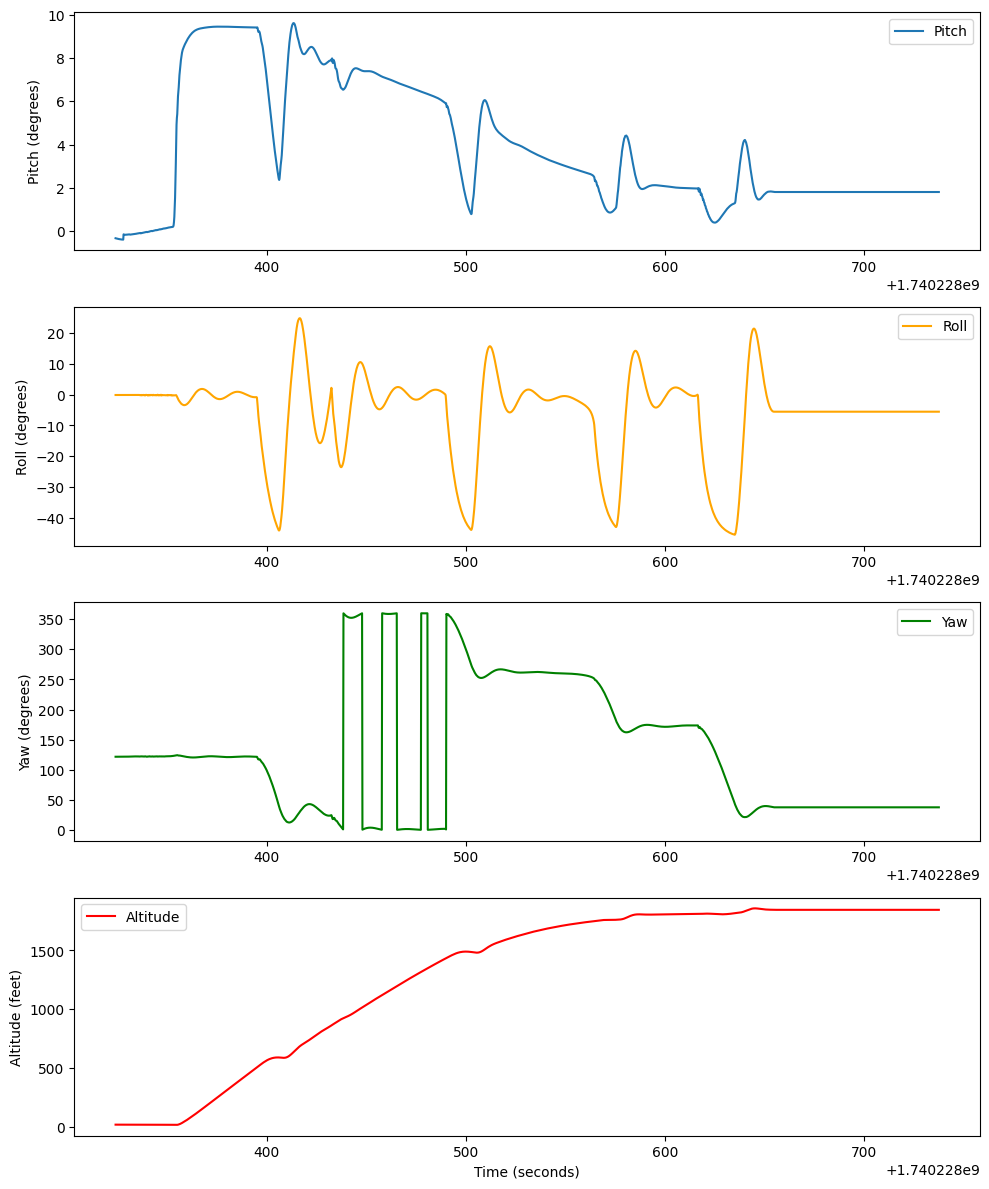

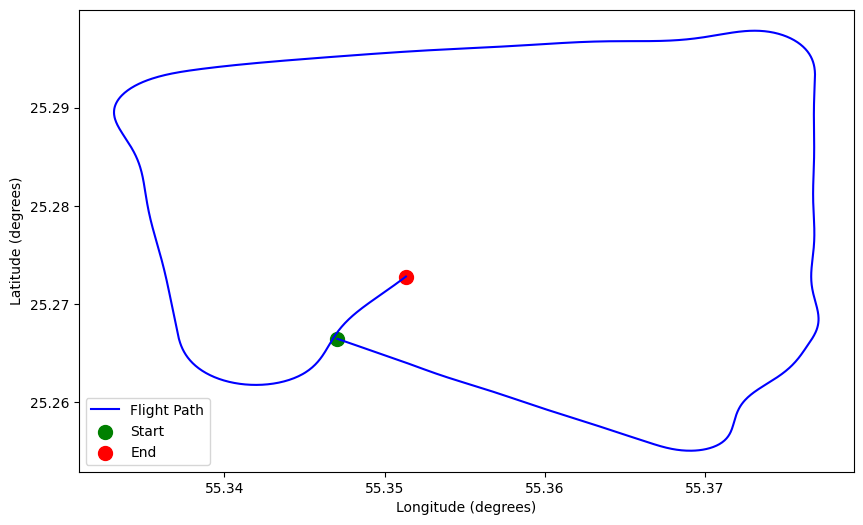

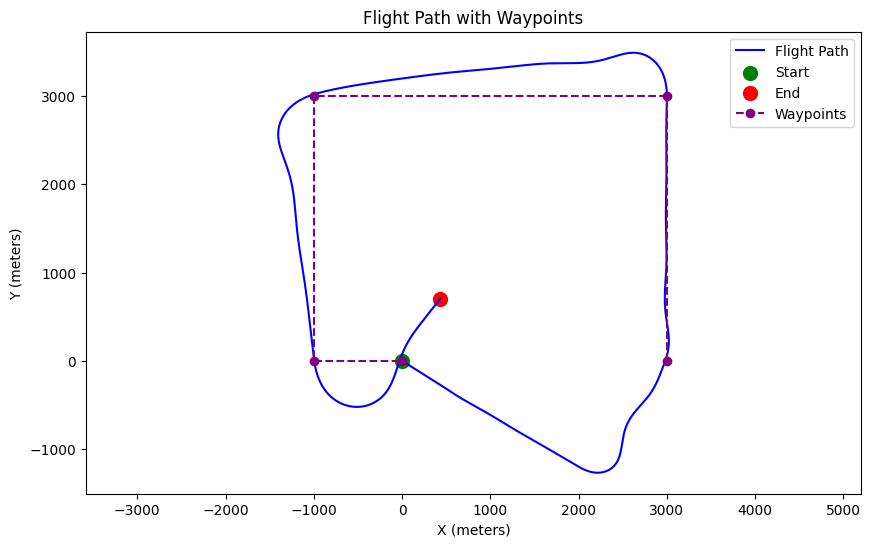

In [21]:
import numpy as np


# Plotting the data after the loop ends
plt.figure(figsize=(10, 12))

# Plot orientation data
plt.subplot(4, 1, 1)
plt.plot(time_data, pitch_data, label='Pitch')
plt.ylabel('Pitch (degrees)')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(time_data, roll_data, label='Roll', color='orange')
plt.ylabel('Roll (degrees)')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(time_data, yaw_data, label='Yaw', color='green')
plt.ylabel('Yaw (degrees)')
plt.legend()

# Plot position data
plt.subplot(4, 1, 4)
plt.plot(time_data, altitude_data, label='Altitude', color='red')
plt.ylabel('Altitude (feet)')
plt.xlabel('Time (seconds)')
plt.legend()

plt.tight_layout()
plt.show()

# Plot x, y position data
# Plot x, y position data
plt.figure(figsize=(10, 6))
plt.plot(x_data, y_data, label='Flight Path', color='blue')
plt.scatter(x_data[0], y_data[0], color='green', s=100, label='Start')  # First point green
plt.scatter(x_data[-1], y_data[-1], color='red', s=100, label='End')    # Last point red
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.legend()
plt.show()


# Reference point (use the first lat/lon as the origin)
lat_ref = y_data[0]  # First latitude
lon_ref = x_data[0]  # First longitude

# Approximate conversion factors (meters per degree)
lat_to_m = 111320  # Approximate meters per degree latitude
lon_to_m = 111320 * np.cos(np.radians(lat_ref))  # Adjusted for latitude

# Convert lat/lon to x, y in meters relative to the first point
x = (np.array(x_data) - lon_ref) * lon_to_m
y = (np.array(y_data) - lat_ref) * lat_to_m

# Extract waypoints into x and y lists
way_x, way_y = zip(*waypoints)

# Plot the flight path
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Flight Path', color='blue')

# Start and End markers
plt.scatter(x[0], y[0], color='green', s=100, label='Start')
plt.scatter(x[-1], y[-1], color='red', s=100, label='End')

# Plot waypoints
plt.plot(way_x, way_y, linestyle='dashed', color='purple', marker='o', markersize=6, label='Waypoints')

# Labels and legend
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')
plt.legend()
plt.title('Flight Path with Waypoints')
plt.axis('equal')  # Keep aspect ratio

# Show plot
plt.show()